In [1]:
import numpy as np 
import pandas as pd 
import os
from time import time
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
from numba import jit
import itertools
from seaborn import countplot,lineplot, barplot
from numba import jit
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')
import gc
gc.enable()

print ("Ready !")

Ready !


In [2]:
from imblearn.over_sampling import SMOTE, ADASYN

In [3]:
sm = SMOTE(random_state=2)
ada = ADASYN(random_state=42)

In [4]:
target = pd.read_csv('y_train.csv')
tr = pd.read_csv('x_train.csv')
data = pd.read_csv('x_train.csv')
test = pd.read_csv('x_test.csv')
sub = pd.read_csv('sample_submission.csv')
print('Data is ready !!')

Data is ready !!


In [5]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [6]:
def fe_step0 (actual):
    
    # https://www.mathworks.com/help/aeroblks/quaternionnorm.html
    # https://www.mathworks.com/help/aeroblks/quaternionmodulus.html
    # https://www.mathworks.com/help/aeroblks/quaternionnormalize.html
        
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    
    return actual

In [7]:
data = data.drop(['row_id', 'measurement_number'], axis=1)

In [8]:
test = test.drop(['row_id', 'measurement_number'], axis=1)

In [9]:
data = fe_step0(data)
test = fe_step0(test)
print(data.shape)
data.head()

(487680, 17)


,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W
0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597
1,0,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600
2,0,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597
3,0,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597
4,0,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596


In [10]:
def fe_step1 (actual):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = actual['norm_X'].tolist(), actual['norm_Y'].tolist(), actual['norm_Z'].tolist(), actual['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

In [11]:
data = fe_step1(data)
test = fe_step1(test)
print (data.shape)
data.head()

(487680, 20)


,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


In [12]:
def feat_eng(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_mean_change_of_abs_change'] = data.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

In [13]:
%%time
data = feat_eng(data)
test = feat_eng(test)
print ("New features: ",data.shape)

New features:  (3810, 276)
Wall time: 2min 35s


In [14]:
data.fillna(0,inplace=True)
test.fillna(0,inplace=True)
data.replace(-np.inf,0,inplace=True)
data.replace(np.inf,0,inplace=True)
test.replace(-np.inf,0,inplace=True)
test.replace(np.inf,0,inplace=True)

In [15]:
data.head()

,series_id,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,...,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z,totl_anglr_vel,totl_linr_acc,totl_xyz,acc_vs_vel
0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,...,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667,0.109076,10.005392,0.994368,91.728917
1,0,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,...,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651,0.074240,9.538638,0.994364,128.483970
2,0,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,...,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677,0.030428,8.874697,0.994372,291.666195
3,0,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,...,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712,0.025082,10.164638,0.994374,405.249042
4,0,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,...,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698,0.010603,10.556132,0.994368,995.561076


In [16]:
target.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [17]:
target['surface'] = le.fit_transform(target['surface'])

In [18]:
target['surface'].value_counts()

1    779
5    732
8    607
7    514
2    363
4    308
6    297
0    189
3     21
Name: surface, dtype: int64

In [19]:
data = target.merge(data, on='series_id')

In [20]:
print(len(target))
target.head()

3810


,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6


In [21]:
print(len(data))
data.head()

487680


,series_id,group_id,surface,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z,totl_anglr_vel,totl_linr_acc,totl_xyz,acc_vs_vel
0,0,13,2,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667,0.109076,10.005392,0.994368,91.728917
1,0,13,2,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,...,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651,0.074240,9.538638,0.994364,128.483970
2,0,13,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677,0.030428,8.874697,0.994372,291.666195
3,0,13,2,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712,0.025082,10.164638,0.994374,405.249042
4,0,13,2,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698,0.010603,10.556132,0.994368,995.561076


In [22]:
fc_vd = data[data['surface']==0]
co_vd = data[data['surface']==1]
st_vd = data[data['surface']==2]
ti_vd = data[data['surface']==3]
sp_vd = data[data['surface']==4]
htls_vd = data[data['surface']==5]
ca_vd = data[data['surface']==6]
ht_vd = data[data['surface']==7]
wo_vd = data[data['surface']==8]

In [23]:
nfc_vd = data[data['surface']!=0]
nco_vd = data[data['surface']!=1]
nst_vd = data[data['surface']!=2]
nti_vd = data[data['surface']!=3]
nsp_vd = data[data['surface']!=4]
nhtls_vd = data[data['surface']!=5]
nca_vd = data[data['surface']!=6]
nht_vd = data[data['surface']!=7]
nwo_vd = data[data['surface']!=8]

In [24]:
nfc_vd['surface']=9
nco_vd['surface']=9
nst_vd['surface']=9
nti_vd['surface']=9
nsp_vd['surface']=9
nhtls_vd['surface']=9
nca_vd['surface']=9
nht_vd['surface']=9
nwo_vd['surface']=9

In [25]:
print(len(fc_vd))
fc_vd.head()

24192


,series_id,group_id,surface,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z,totl_anglr_vel,totl_linr_acc,totl_xyz,acc_vs_vel
1536,12,25,0,0.32934,0.93215,0.14474,0.041121,-0.024627,-0.041002,0.249150,...,0.932146,0.144739,0.041121,2.840071,-0.018676,2.465185,0.253699,10.946609,0.999159,43.147952
1537,12,25,0,0.32959,0.93205,0.14475,0.041166,-0.024144,-0.061916,0.208150,...,0.932053,0.144750,0.041166,2.840025,-0.018680,2.464642,0.218502,10.574080,0.999149,48.393607
1538,12,25,0,0.32985,0.93195,0.14478,0.041222,-0.016482,-0.042705,0.162060,...,0.931954,0.144781,0.041222,2.839935,-0.018679,2.464079,0.168401,11.253938,0.999146,66.828307
1539,12,25,0,0.33000,0.93190,0.14478,0.041241,-0.003465,-0.034831,0.124620,...,0.931900,0.144780,0.041241,2.839926,-0.018691,2.463761,0.129442,10.658223,0.999149,82.339479
1540,12,25,0,0.33007,0.93187,0.14477,0.041280,-0.007041,-0.039649,0.057265,...,0.931875,0.144771,0.041280,2.839919,-0.018635,2.463599,0.070006,10.384162,0.999143,148.331604


In [26]:
print(len(nfc_vd))
nfc_vd.head()

463488


,series_id,group_id,surface,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z,totl_anglr_vel,totl_linr_acc,totl_xyz,acc_vs_vel
0,0,13,9,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667,0.109076,10.005392,0.994368,91.728917
1,0,13,9,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,...,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651,0.074240,9.538638,0.994364,128.483970
2,0,13,9,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677,0.030428,8.874697,0.994372,291.666195
3,0,13,9,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712,0.025082,10.164638,0.994374,405.249042
4,0,13,9,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698,0.010603,10.556132,0.994368,995.561076


In [27]:
fc_d = pd.concat((fc_vd, nfc_vd))
co_d = pd.concat((co_vd, nco_vd))
st_d = pd.concat((st_vd, nst_vd))
ti_d = pd.concat((ti_vd, nti_vd))
sp_d = pd.concat((sp_vd, nsp_vd))
htls_d = pd.concat((htls_vd, nhtls_vd))
ca_d = pd.concat((ca_vd, nca_vd))
ht_d = pd.concat((ht_vd, nht_vd))
wo_d = pd.concat((wo_vd, nwo_vd))

In [28]:
fc_t = fc_d['surface']
co_t = co_d['surface']
st_t = st_d['surface']
ti_t = ti_d['surface']
sp_t = sp_d['surface']
htls_t = htls_d['surface']
ca_t = ca_d['surface']
ht_t = ht_d['surface']
wo_t = wo_d['surface']

In [29]:
print(len(fc_d))
fc_d.head()

487680


,series_id,group_id,surface,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z,totl_anglr_vel,totl_linr_acc,totl_xyz,acc_vs_vel
1536,12,25,0,0.32934,0.93215,0.14474,0.041121,-0.024627,-0.041002,0.249150,...,0.932146,0.144739,0.041121,2.840071,-0.018676,2.465185,0.253699,10.946609,0.999159,43.147952
1537,12,25,0,0.32959,0.93205,0.14475,0.041166,-0.024144,-0.061916,0.208150,...,0.932053,0.144750,0.041166,2.840025,-0.018680,2.464642,0.218502,10.574080,0.999149,48.393607
1538,12,25,0,0.32985,0.93195,0.14478,0.041222,-0.016482,-0.042705,0.162060,...,0.931954,0.144781,0.041222,2.839935,-0.018679,2.464079,0.168401,11.253938,0.999146,66.828307
1539,12,25,0,0.33000,0.93190,0.14478,0.041241,-0.003465,-0.034831,0.124620,...,0.931900,0.144780,0.041241,2.839926,-0.018691,2.463761,0.129442,10.658223,0.999149,82.339479
1540,12,25,0,0.33007,0.93187,0.14477,0.041280,-0.007041,-0.039649,0.057265,...,0.931875,0.144771,0.041280,2.839919,-0.018635,2.463599,0.070006,10.384162,0.999143,148.331604


In [30]:
print(len(fc_t))
print(fc_t.head())
fc_t.tail()

487680
1536    0
1537    0
1538    0
1539    0
1540    0
Name: surface, dtype: int64


487675    9
487676    9
487677    9
487678    9
487679    9
Name: surface, dtype: int64

In [31]:
# # make the groups
# x = 0
# groups = []

# for group in data['group_id'].unique():
#     groups.append(data[data['group_id']==x])
#     x += 1

# groups

In [32]:
# # make the group labels
# x = 0
# groups_labels = []

# for group in groups:
# #     groups_labels.append(groups[x][np.array(['series_id', 'group_id', 'surface', 'row_id'])])
#     groups_labels.append(groups[x][np.array(['surface'])])
#     x += 1

# groups_labels

SMOTE SECTION


In [33]:
data_sm, lab_sm = sm.fit_sample(co_d,co_t)

In [61]:
df_sm = pd.DataFrame(data_sm, columns=data.columns.values)

In [62]:
t_sm = df_sm['surface']

In [63]:
t_sm

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
5         1.0
6         1.0
7         1.0
8         1.0
9         1.0
10        1.0
11        1.0
12        1.0
13        1.0
14        1.0
15        1.0
16        1.0
17        1.0
18        1.0
19        1.0
20        1.0
21        1.0
22        1.0
23        1.0
24        1.0
25        1.0
26        1.0
27        1.0
28        1.0
29        1.0
         ... 
775906    1.0
775907    1.0
775908    1.0
775909    1.0
775910    1.0
775911    1.0
775912    1.0
775913    1.0
775914    1.0
775915    1.0
775916    1.0
775917    1.0
775918    1.0
775919    1.0
775920    1.0
775921    1.0
775922    1.0
775923    1.0
775924    1.0
775925    1.0
775926    1.0
775927    1.0
775928    1.0
775929    1.0
775930    1.0
775931    1.0
775932    1.0
775933    1.0
775934    1.0
775935    1.0
Name: surface, Length: 775936, dtype: float64

In [36]:
# print(lab_sm.shape)
# print(len(lab_head))
# print(lab_sm.head())

In [37]:
target = data['surface']

In [100]:
data = data.drop(['series_id', 'group_id', 'surface'], axis=1)

In [ ]:
fc_d = fc_d.drop(['series_id', 'group_id', 'surface'], axis=1)
co_d = co_d.drop(['series_id', 'group_id', 'surface'], axis=1)
st_d = st_d.drop(['series_id', 'group_id', 'surface'], axis=1)
ti_d = ti_d.drop(['series_id', 'group_id', 'surface'], axis=1)
sp_d = sp_d.drop(['series_id', 'group_id', 'surface'], axis=1)
htls_d = htls_d.drop(['series_id', 'group_id', 'surface'], axis=1)
ca_d = ca_d.drop(['series_id', 'group_id', 'surface'], axis=1)
ht_d = ht_d.drop(['series_id', 'group_id', 'surface'], axis=1)
wo_d = wo_d.drop(['series_id', 'group_id', 'surface'], axis=1)

In [45]:
# df_sm = df_sm.drop(['series_id'], axis=1)

In [48]:
test = test.drop(['series_id'], axis=1)

In [65]:
print(len(test))
test.head()

488448


,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z,totl_anglr_vel,totl_linr_acc,totl_xyz,acc_vs_vel
0,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439,0.999991,0.999996,-0.025773,-0.988644,-0.148011,0.003350,2.844735,-0.014254,3.091598,0.028177,6.959611,0.999990,247.000018
1,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273,0.999992,0.999996,-0.025683,-0.988624,-0.148161,0.003439,2.844435,-0.014411,3.091804,0.153987,8.992450,0.999990,58.397648
2,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990,1.000000,1.000000,-0.025617,-0.988610,-0.148260,0.003571,2.844239,-0.014658,3.091976,0.145114,11.619024,0.999993,80.068203
3,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270,0.999990,0.999995,-0.025566,-0.988625,-0.148171,0.003609,2.844420,-0.014712,3.092086,0.085687,12.387813,0.999989,144.570382
4,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100,0.999994,0.999997,-0.025548,-0.988663,-0.147920,0.003477,2.844920,-0.014434,3.092079,0.155550,11.300393,0.999991,72.648208


In [50]:
test = test.iloc[:,4:23]

In [70]:
df_sm.head()

,series_id,group_id,surface,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z,totl_anglr_vel,totl_linr_acc,totl_xyz,acc_vs_vel
0,1.0,31.0,1.0,-0.95896,0.24074,0.030758,-0.14661,0.283420,0.002192,-0.050810,...,0.240740,0.030758,-0.146610,2.841074,-0.011599,-0.490164,0.287947,9.484484,0.989195,32.938319
1,1.0,31.0,1.0,-0.95890,0.24079,0.030786,-0.14693,0.108930,-0.009485,0.009155,...,0.240789,0.030786,-0.146930,2.840434,-0.011717,-0.490270,0.109725,6.269381,0.989150,57.137344
2,1.0,31.0,1.0,-0.95889,0.24076,0.030807,-0.14702,-0.073197,0.003959,-0.023384,...,0.240760,0.030807,-0.147020,2.840246,-0.011712,-0.490215,0.076943,7.534083,0.989133,97.917209
3,1.0,31.0,1.0,-0.95888,0.24076,0.030742,-0.14712,-0.064979,0.068265,0.018673,...,0.240759,0.030742,-0.147120,2.840082,-0.011886,-0.490193,0.096078,11.639655,0.989121,121.147454
4,1.0,31.0,1.0,-0.95888,0.24079,0.030707,-0.14702,0.077929,0.005519,0.022119,...,0.240791,0.030707,-0.147021,2.840293,-0.011914,-0.490249,0.081195,12.343067,0.989128,152.017404


In [73]:
x = df_sm.iloc[:,7:26]
y = t_sm
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)
predicted = np.zeros((test.shape[0],2))
measured= np.zeros((x.shape[0]))
score = 0

Fold: 0 score: 0.945601464030724


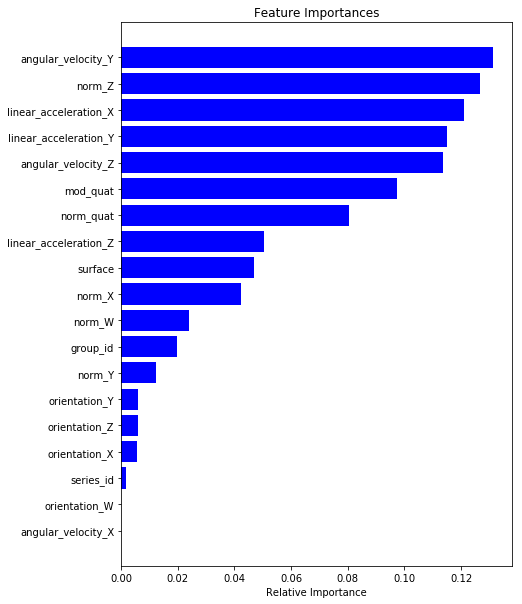

Fold: 1 score: 0.9463102817228136


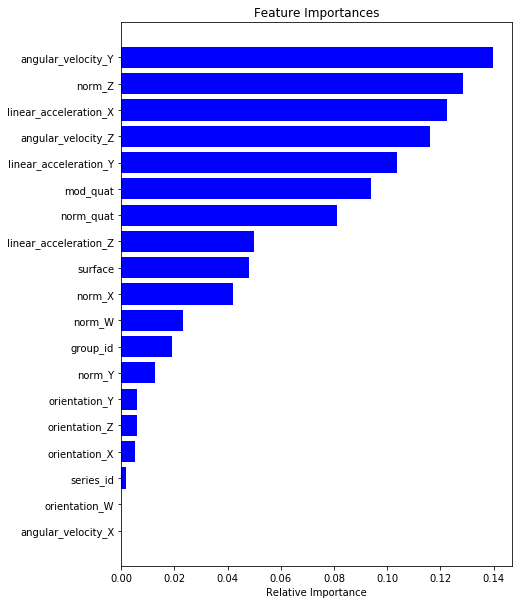

Fold: 2 score: 0.944454468128979


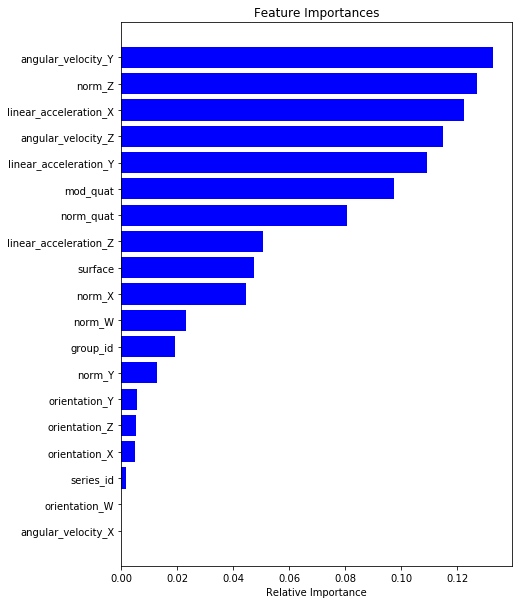

Fold: 3 score: 0.945640126813929


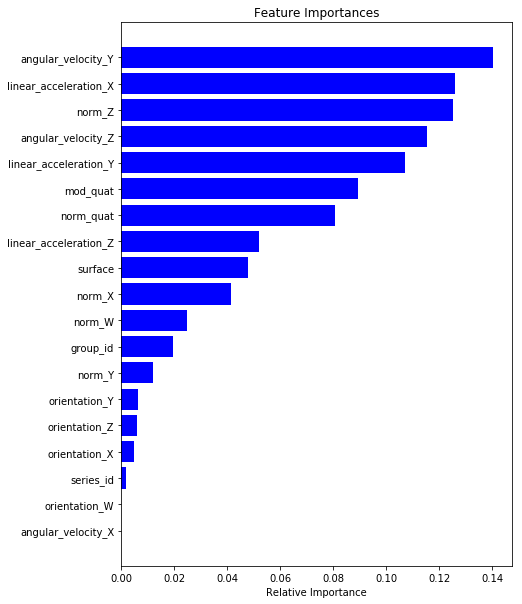

Fold: 4 score: 0.9447379952058149


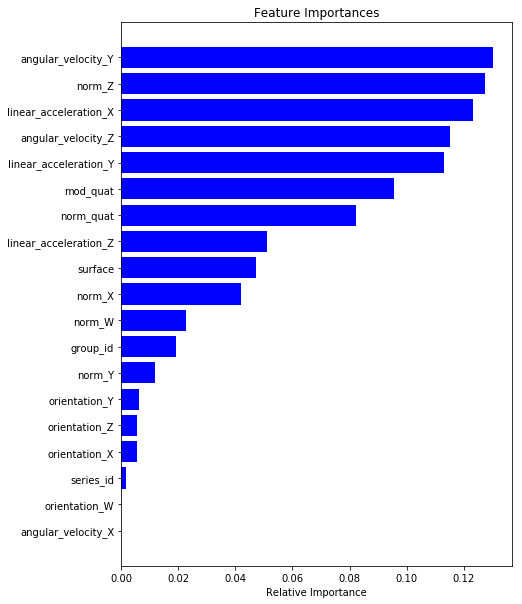

Fold: 5 score: 0.9457303399747403


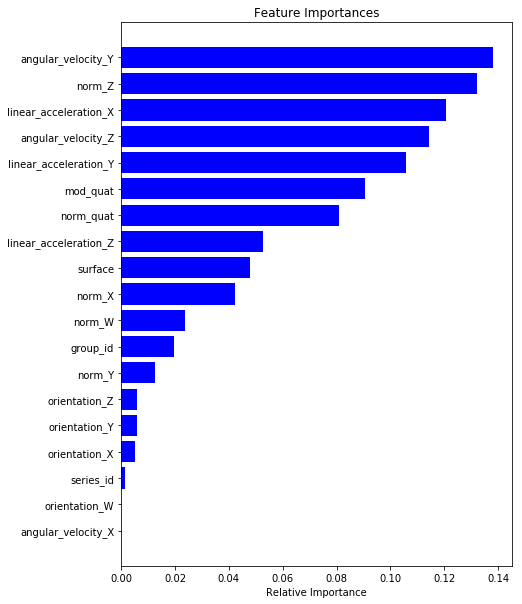

Fold: 6 score: 0.9443255921849627


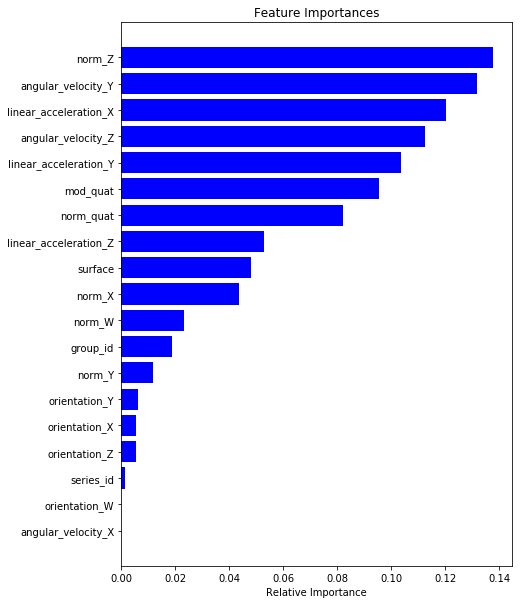

Fold: 7 score: 0.9456787895971338


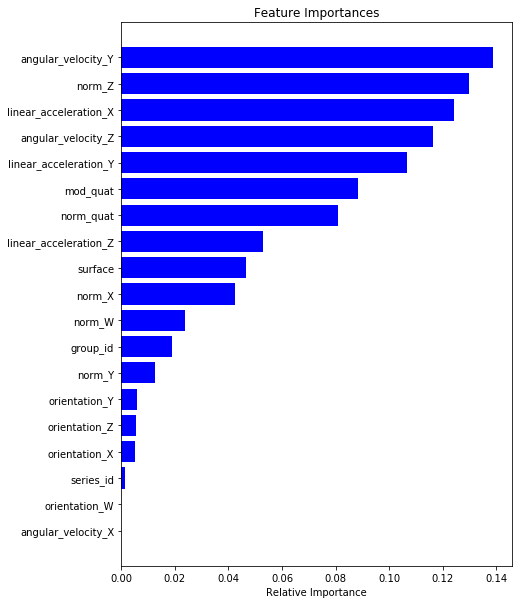

Fold: 8 score: 0.9463733374574699


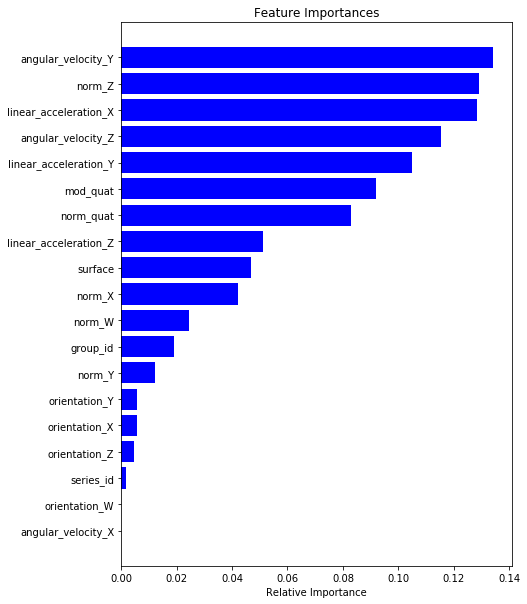

Fold: 9 score: 0.9445948035879987


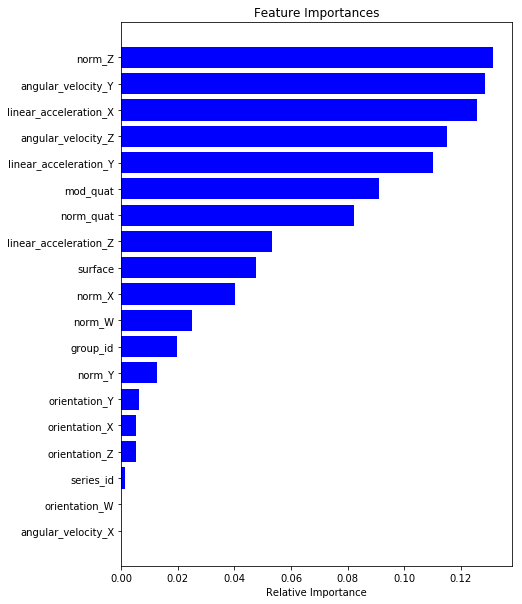

In [72]:
# For whole data
for times, (trn_idx, val_idx) in enumerate(folds.split(x.values,y.values)):
#     model = RandomForestClassifier(n_estimators=500, n_jobs = -1)
    model = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=5, n_jobs=-1)
    model.fit(x.iloc[trn_idx],y[trn_idx])
    measured[val_idx] = model.predict(x.iloc[val_idx])
    predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(x.iloc[val_idx],y[val_idx])
    print("Fold: {} score: {}".format(times,model.score(x.iloc[val_idx],y[val_idx])))

    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = data.columns
    
    if model.score(x.iloc[val_idx],y[val_idx]) > 0.92000:
        hm = 30
        plt.figure(figsize=(7, 10))
        plt.title('Feature Importances')
        plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
        plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    gc.collect()

In [74]:
print('Avg Accuracy RF', score / folds.n_splits)

Avg Accuracy RF 0.0


In [75]:
preds = predicted.argmax(axis=1)[0:-1:128]
preds.shape

(3816,)

In [76]:
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [77]:
sub['surface'] = le.inverse_transform(preds)
# sub.to_csv('submission2.csv', index=False)
# sub[sub['surface']==1]

In [78]:
sub

,series_id,surface
0,0,carpet
1,1,carpet
2,2,carpet
3,3,carpet
4,4,carpet
5,5,carpet
6,6,carpet
7,7,carpet
8,8,carpet
9,9,carpet


In [ ]:
sub073 = pd.read_csv('../input/robots-best-submission/mybest0.73.csv')
sub072 = pd.read_csv('../input/robots-best-submission/sub_0.72.csv')
sub072_2 = pd.read_csv('../input/robots-best-submission/sub_0.72_2.csv')
sub071 = pd.read_csv('../input/robots-best-submission/sub_0.71.csv')
sub06 = pd.read_csv('../input/robots-best-submission/sub_0.6.csv')

sub073 = sub073.rename(columns = {'surface':'surface073'})
sub072 = sub072.rename(columns = {'surface':'surface072'})
sub072_2 = sub072_2.rename(columns = {'surface':'surface072_2'})
sub071 = sub071.rename(columns = {'surface':'surface071'})
sub06 = sub06.rename(columns = {'surface':'surface06'})
print ("Submission data is ready")

In [ ]:
subtest = pd.concat([sub073['series_id'], sub073['surface073'], sub072['surface072'], sub071['surface071'], sub06['surface06']], axis=1)
subtest.head()

In [ ]:
differents = []
for i in range (0,subtest.shape[0]): 
    labels = list(subtest.iloc[i,1:])
    result = len(set(labels))>1
    if result:
        differents.append((i, str(labels)))
        
differents = pd.DataFrame(differents, columns=['idx','group']) 
differents.head()

In [ ]:
differents['group'].nunique()

In [ ]:
differents['count'] = differents.groupby('group')['group'].transform('count')
differents = differents.sort_values(by=['count'], ascending=False)
differents = differents.drop(['idx'],axis=1)
differents = differents.drop_duplicates()

In [ ]:
differents.head(10)

In [ ]:
differents.tail(10)